In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

torch.cuda.is_available()

c:\Users\QbaSo\AppData\Local\Programs\Python\Python39\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


True

In [2]:
batch_size_train = 64
batch_size_test = 1000

log_interval = 10

In [3]:
def MNIST():
  MNIST_train = torchvision.datasets.MNIST('/files/', train=True, download=True,
                              transform=torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(
                                  (0.1307,), (0.3081,))
                              ]))
  MNIST_test = torchvision.datasets.MNIST('/files/', train=False, download=True,
                              transform=torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(
                                  (0.1307,), (0.3081,))
                              ]))

  train_loader = torch.utils.data.DataLoader(MNIST_train, batch_size=batch_size_train, shuffle=True)
  test_loader = torch.utils.data.DataLoader(MNIST_test, batch_size=batch_size_test, shuffle=True)
  return train_loader, test_loader

def permute_mnist(mnist, seed):
    """ Given the training set, permute pixels of each img the same way. """

    np.random.seed(seed)
    print("starting permutation...")
    perm_inds = list(range(28*28))
    np.random.shuffle(perm_inds)
    for i in range(len(mnist.data)):
        mnist.data[i] = mnist.data[i].flatten()[perm_inds].reshape(28,28)
    print("done.")

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

def train(model, optimizer, train_loader, epoch=1):
  train_losses = []
  model.train()
  for e in range(epoch):
      for batch_idx, (data, target) in enumerate(train_loader):
          optimizer.zero_grad()
          output = model(data)
          loss = F.cross_entropy(output, target)
          loss.backward()
          optimizer.step()
          if batch_idx % log_interval == 0:
              print(f"Epoch {e+1} [{batch_idx * len(data)} / {len(train_loader.dataset)}]       loss: {loss.item()}")
          train_losses.append(loss.item())
  return train_losses

def test(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
      for data, target in test_loader:
          output = model(data)
          test_loss += F.cross_entropy(output, target, size_average=False).item()
          pred = output.data.max(1, keepdim=True)[1]
          correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))

# Normal learning

Epoch 1 [0 / 60000]       loss: 2.3178062438964844
Epoch 1 [640 / 60000]       loss: 2.2610607147216797
Epoch 1 [1280 / 60000]       loss: 2.1018764972686768
Epoch 1 [1920 / 60000]       loss: 1.7736568450927734
Epoch 1 [2560 / 60000]       loss: 1.379608392715454
Epoch 1 [3200 / 60000]       loss: 1.475439429283142
Epoch 1 [3840 / 60000]       loss: 0.860030472278595
Epoch 1 [4480 / 60000]       loss: 0.8178694248199463
Epoch 1 [5120 / 60000]       loss: 1.227351188659668
Epoch 1 [5760 / 60000]       loss: 1.095969319343567
Epoch 1 [6400 / 60000]       loss: 0.626713216304779
Epoch 1 [7040 / 60000]       loss: 0.900736391544342
Epoch 1 [7680 / 60000]       loss: 0.7219827771186829
Epoch 1 [8320 / 60000]       loss: 0.7742299437522888
Epoch 1 [8960 / 60000]       loss: 0.46004411578178406
Epoch 1 [9600 / 60000]       loss: 0.6083566546440125
Epoch 1 [10240 / 60000]       loss: 0.5683521628379822
Epoch 1 [10880 / 60000]       loss: 0.9639973640441895
Epoch 1 [11520 / 60000]       loss: 

C:\Users\QbaSo\AppData\Roaming\Python\Python39\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0924, Accuracy: 9719/10000 (97%)



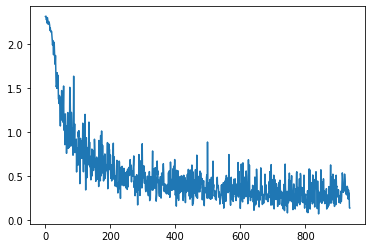

In [5]:
train_loader, test_loader = MNIST()

model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.1)
train_losses = train(model, optimizer, train_loader)
plt.plot(train_losses)
test(model, test_loader)

# Learning Permuted Mnist

In [20]:
train_loader, test_loader = MNIST()

permute_mnist(train_loader.dataset, 2137)
model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.1)
train_losses = train(model, optimizer)
plt.plot(train_losses)
test(model)

starting permutation...


KeyboardInterrupt: 

# Pretraining on noise data

In [5]:
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

def dead_leaves_squares():
    imagefolder = "data/dead_leaves-squares/"
    batch_size = 128
    resize_image = True

    class TwoCropsTransform:
        """Take two random crops of one image as the query and key."""

        def __init__(self, base_transform):
            self.base_transform = base_transform

        def __call__(self, x):
            q = self.base_transform(x)
            k = self.base_transform(x)
            return [q, k]

    transform_array = []
    if resize_image:
        transform_array.append(
            torchvision.transforms.Resize((96,96))
        )

    transform_array += [
        torchvision.transforms.RandomResizedCrop(64, scale=(0.08, 1)),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ColorJitter(0.4, 0.4, 0.4, 0.4),
        torchvision.transforms.RandomGrayscale(p=0.2),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            (0.44087801806139126, 0.42790631331699347, 0.3867879370752931),
            (0.26826768628079806, 0.2610450402318512, 0.26866836876860795),
        ),
    ]

    transform = torchvision.transforms.Compose(transform_array)
    transform = TwoCropsTransform(transform)


    train_path = os.path.join(imagefolder, 'train')
    print(f'Loading data from {imagefolder} as imagefolder')
    dataset = torchvision.datasets.ImageFolder(
        train_path,
        transform=transform)

    val_split = 0.3
    train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    train_dataset = Subset(dataset, train_idx).dataset
    test_dataset = Subset(dataset, test_idx).dataset

    # loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=2, shuffle=True, pin_memory=True)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=2, shuffle=True, pin_memory=True)
    return train_loader, test_loader

In [5]:
imagefolder = "data"#/dead_leaves-squares"
batch_size = 128
resize_image = True

class TwoCropsTransform:
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform):
        self.base_transform = base_transform

    def __call__(self, x):
        q = self.base_transform(x)
        k = self.base_transform(x)
        return [q, k]

transform_array = []
if resize_image:
    transform_array.append(
        torchvision.transforms.Resize((96,96))
    )

transform_array += [
    torchvision.transforms.RandomResizedCrop(64, scale=(0.08, 1)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ColorJitter(0.4, 0.4, 0.4, 0.4),
    torchvision.transforms.RandomGrayscale(p=0.2),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        (0.44087801806139126, 0.42790631331699347, 0.3867879370752931),
        (0.26826768628079806, 0.2610450402318512, 0.26866836876860795),
    ),
]

transform = torchvision.transforms.Compose(transform_array)
transform = TwoCropsTransform(transform)


train_path = os.path.join(imagefolder, 'train')
print(f'Loading data from {imagefolder} as imagefolder')
dataset = torchvision.datasets.ImageFolder(
    train_path,
    transform=transform)

val_split = 0.3
train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
# train_dataset = Subset(dataset, train_idx).dataset
# test_dataset = Subset(dataset, test_idx).dataset

# loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=2, shuffle=True, pin_memory=True)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=2, shuffle=True, pin_memory=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=2, shuffle=True, pin_memory=True)

Loading data from data as imagefolder


In [6]:
# train_loader, test_loader = dead_leaves_squares()

model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.1)
train_losses = train(model, optimizer, train_loader)
# plt.plot(train_loader)
# test(model, test_loader)

# freeze and train on MNIST

In [6]:
model.conv1.requires_grad_(False)
model.conv2.requires_grad_(False)
model.conv2_drop.requires_grad_(False)
model.fc1.requires_grad_(False)
model.fc2.requires_grad_(False)

Linear(in_features=50, out_features=10, bias=True)